In [6]:
# 导入必要的库
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from config.strategy_config import StrategyConfig

# 初始化配置
config = StrategyConfig("../config/default_config.yaml")
print("✅ 配置加载完成")

# 创建示例数据
symbols = ["000001", "000002", "600000", "600036"]
dates = pd.date_range("2024-01-01", periods=50, freq="D")

# 模拟价格数据
np.random.seed(42)
prices = pd.DataFrame(
    np.random.randn(50, 4).cumsum(axis=0) + 100,
    index=dates,
    columns=symbols
)

# 计算收益率
returns = prices.pct_change().dropna()

# 模拟预期收益
expected_returns = pd.Series([0.001, 0.002, 0.0005, 0.0015], index=symbols)

print(f"股票收益率数据形状: {returns.shape}")
print(f"预期收益率: {expected_returns.to_dict()}")
print(f"收益率统计:")
print(returns.describe())

# 计算协方差矩阵
cov_matrix = returns.cov()
print(f"\n协方差矩阵形状: {cov_matrix.shape}")

print("\n✅ 数据准备完成")


配置文件 ../config/default_config.yaml 加载成功
✅ 配置加载完成
股票收益率数据形状: (49, 4)
预期收益率: {'000001': 0.001, '000002': 0.002, '600000': 0.0005, '600036': 0.0015}
收益率统计:
          000001     000002     600000     600036
count  49.000000  49.000000  49.000000  49.000000
mean   -0.001014   0.000065  -0.001573   0.000437
std     0.007179   0.009899   0.010325   0.010334
min    -0.014744  -0.020181  -0.026943  -0.019098
25%    -0.006828  -0.005266  -0.009553  -0.007930
50%    -0.000365   0.001128  -0.000743   0.001739
75%     0.002736   0.004872   0.003731   0.007960
max     0.019624   0.025891   0.019553   0.027140

协方差矩阵形状: (4, 4)

✅ 数据准备完成


In [ ]:
# 组合优化函数定义
def portfolio_stats(weights, expected_returns, cov_matrix):
    """计算组合统计指标"""
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.0):
    """计算负夏普比率（用于最小化）"""
    portfolio_return, portfolio_volatility = portfolio_stats(weights, expected_returns, cov_matrix)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

def portfolio_variance(weights, cov_matrix):
    """计算组合方差"""
    return np.dot(weights, np.dot(cov_matrix, weights))

def optimize_portfolio(expected_returns, cov_matrix, method='max_sharpe'):
    """组合优化"""
    n_assets = len(expected_returns)
    
    # 约束条件：权重之和为1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # 权重边界：0 <= weight <= 1
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # 初始权重（等权重）
    initial_weights = np.array([1/n_assets] * n_assets)
    
    if method == 'max_sharpe':
        # 最大夏普比率
        result = minimize(negative_sharpe_ratio, initial_weights,
                         args=(expected_returns, cov_matrix),
                         method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'min_variance':
        # 最小方差
        result = minimize(portfolio_variance, initial_weights,
                         args=(cov_matrix,),
                         method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        raise ValueError("method must be 'max_sharpe' or 'min_variance'")
    
    return result

print("✅ 组合优化函数定义完成")


✅ 组合优化函数定义完成


In [ ]:
# 执行不同的组合优化策略
print("=== 组合优化策略比较 ===")

# 1. 等权重策略
equal_weights = pd.Series([0.25, 0.25, 0.25, 0.25], index=symbols)
equal_return, equal_vol = portfolio_stats(equal_weights, expected_returns, cov_matrix)
equal_sharpe = equal_return / equal_vol

print("1. 等权重策略")
print(f"   权重: {equal_weights.to_dict()}")
print(f"   预期收益: {equal_return:.4f}")
print(f"   波动率: {equal_vol:.4f}")
print(f"   夏普比率: {equal_sharpe:.4f}")

# 2. 最大夏普比率策略
max_sharpe_result = optimize_portfolio(expected_returns, cov_matrix, 'max_sharpe')
max_sharpe_weights = pd.Series(max_sharpe_result.x, index=symbols)
max_sharpe_return, max_sharpe_vol = portfolio_stats(max_sharpe_weights, expected_returns, cov_matrix)
max_sharpe_ratio = max_sharpe_return / max_sharpe_vol

print("\n2. 最大夏普比率策略")
print(f"   权重: {max_sharpe_weights.to_dict()}")
print(f"   预期收益: {max_sharpe_return:.4f}")
print(f"   波动率: {max_sharpe_vol:.4f}")
print(f"   夏普比率: {max_sharpe_ratio:.4f}")
print(f"   优化成功: {max_sharpe_result.success}")

# 3. 最小方差策略
min_var_result = optimize_portfolio(expected_returns, cov_matrix, 'min_variance')
min_var_weights = pd.Series(min_var_result.x, index=symbols)
min_var_return, min_var_vol = portfolio_stats(min_var_weights, expected_returns, cov_matrix)
min_var_sharpe = min_var_return / min_var_vol

print("\n3. 最小方差策略")
print(f"   权重: {min_var_weights.to_dict()}")
print(f"   预期收益: {min_var_return:.4f}")
print(f"   波动率: {min_var_vol:.4f}")
print(f"   夏普比率: {min_var_sharpe:.4f}")
print(f"   优化成功: {min_var_result.success}")

print("\n✅ 组合优化完成")


=== 组合优化策略比较 ===
1. 等权重策略
   权重: {'000001': 0.25, '000002': 0.25, '600000': 0.25, '600036': 0.25}
   预期收益: 0.0013
   波动率: 0.0048
   夏普比率: 0.2587

2. 最大夏普比率策略
   权重: {'000001': 0.32720210309591163, '000002': 0.3317794369454132, '600000': 0.14077384275626303, '600036': 0.2002446172024121}
   预期收益: 0.0014
   波动率: 0.0050
   夏普比率: 0.2740
   优化成功: True

3. 最小方差策略
   权重: {'000001': 0.25, '000002': 0.25, '600000': 0.25, '600036': 0.25}
   预期收益: 0.0013
   波动率: 0.0048
   夏普比率: 0.2587
   优化成功: True

✅ 组合优化完成


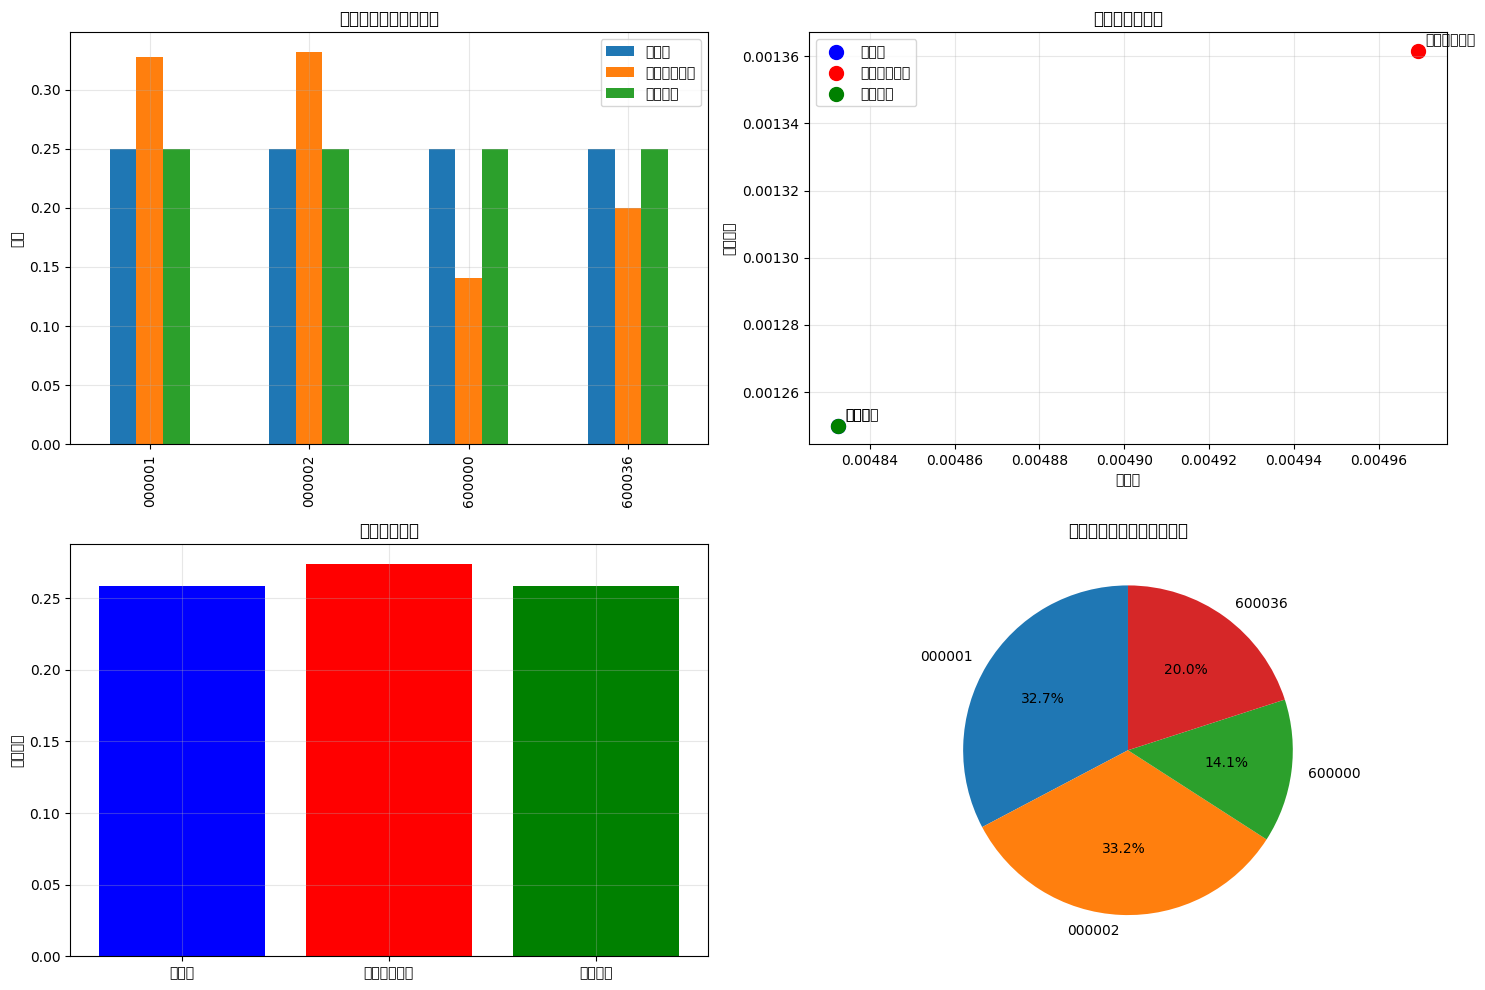


=== 策略对比表 ===
       策略    预期收益     波动率    夏普比率
0     等权重  0.0012  0.0048  0.2587
1  最大夏普比率  0.0014  0.0050  0.2740
2    最小方差  0.0012  0.0048  0.2587

✅ 可视化分析完成


In [ ]:
# 结果可视化
strategies = ['等权重', '最大夏普比率', '最小方差']
weights_data = pd.DataFrame({
    '等权重': equal_weights,
    '最大夏普比率': max_sharpe_weights,
    '最小方差': min_var_weights
})

# 绘制权重分布对比
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 权重分布对比
weights_data.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('不同策略权重分布对比')
axes[0, 0].set_ylabel('权重')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 风险收益散点图
returns_list = [equal_return, max_sharpe_return, min_var_return]
vols_list = [equal_vol, max_sharpe_vol, min_var_vol]
colors = ['blue', 'red', 'green']

for i, (ret, vol, color, strategy) in enumerate(zip(returns_list, vols_list, colors, strategies)):
    axes[0, 1].scatter(vol, ret, color=color, s=100, label=strategy)
    axes[0, 1].annotate(strategy, (vol, ret), xytext=(5, 5), textcoords='offset points')

axes[0, 1].set_xlabel('波动率')
axes[0, 1].set_ylabel('预期收益')
axes[0, 1].set_title('风险收益散点图')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 夏普比率对比
sharpe_ratios = [equal_sharpe, max_sharpe_ratio, min_var_sharpe]
axes[1, 0].bar(strategies, sharpe_ratios, color=['blue', 'red', 'green'])
axes[1, 0].set_title('夏普比率对比')
axes[1, 0].set_ylabel('夏普比率')
axes[1, 0].grid(True, alpha=0.3)

# 权重饼图 - 最大夏普比率策略
axes[1, 1].pie(max_sharpe_weights, labels=symbols, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('最大夏普比率策略权重分布')

plt.tight_layout()
plt.show()

# 策略比较表
comparison_df = pd.DataFrame({
    '策略': strategies,
    '预期收益': returns_list,
    '波动率': vols_list,
    '夏普比率': sharpe_ratios
})

print("\n=== 策略对比表 ===")
print(comparison_df.round(4))

print("\n✅ 可视化分析完成")
